# **PREDICTION OF MILLING MACHINE BEHAVIOR**

## IMPORT LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split ,KFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
import xgboost

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



## DATA LOADING AND ANALYSIS

Datasets elegido: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

In [4]:
df=pd.read_csv('/content/ai4i2020.csv',index_col=0)

## FEATURE ENGINEERING

Eliminamos la columna de RNF

In [5]:
df=df.drop(columns='RNF')

Sacamos la variable potencia = torque x rot speed

In [6]:
#potencia_w = torque * (rpm * 2 * np.pi / 60) (para pasarlo a radianes)

df['Power [W]']=df['Torque [Nm]']*(df['Rotational speed [rpm]']*(2*np.pi/60))

In [7]:
df['Disipation']=df['Process temperature [K]']-df['Air temperature [K]']

Aplicamos dummies para poder tener en cuenta los valores de dureza de la herramienta: L (Low),M (Medium) y H (High)

In [8]:
#Probado también con los valores medios de las durezas de cada tipo de herramienta, pero se obtuvo peores resultados:
""" df['Type'].replace('L',600,inplace=True)
df['Type'].replace('M',1000,inplace=True)
df['Type'].replace('H',2000,inplace=True) """

" df['Type'].replace('L',600,inplace=True)\ndf['Type'].replace('M',1000,inplace=True)\ndf['Type'].replace('H',2000,inplace=True) "

In [9]:
df = pd.get_dummies(df, columns=['Type'])

In [10]:
df_aux=df[['Machine failure','TWF','HDF','PWF','OSF']]
df=df.drop(columns=['Machine failure','TWF','HDF','PWF','OSF'])
df['Machine failure']=df_aux['Machine failure']
df['TWF']=df_aux['TWF']
df['HDF']=df_aux['HDF']
df['PWF']=df_aux['PWF']
df['OSF']=df_aux['OSF']



In [11]:
df.head(2)

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Disipation,Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,,
1,M14860,298.1,308.6,1551,42.8,0,6951.590560,10.5,False,False,True,0,0,0,0,0
2,L47181,298.2,308.7,1408,46.3,3,6826.722724,10.5,False,True,False,0,0,0,0,0


Para la hora de predecir el modo de fallo mediante un modelo de clasificación, será mejor agruparlos en una columna los 4 tipos para tener un único target

## VISUALIZATION

Visualizamos en un primer momento todo el dataframe:

<Axes: >

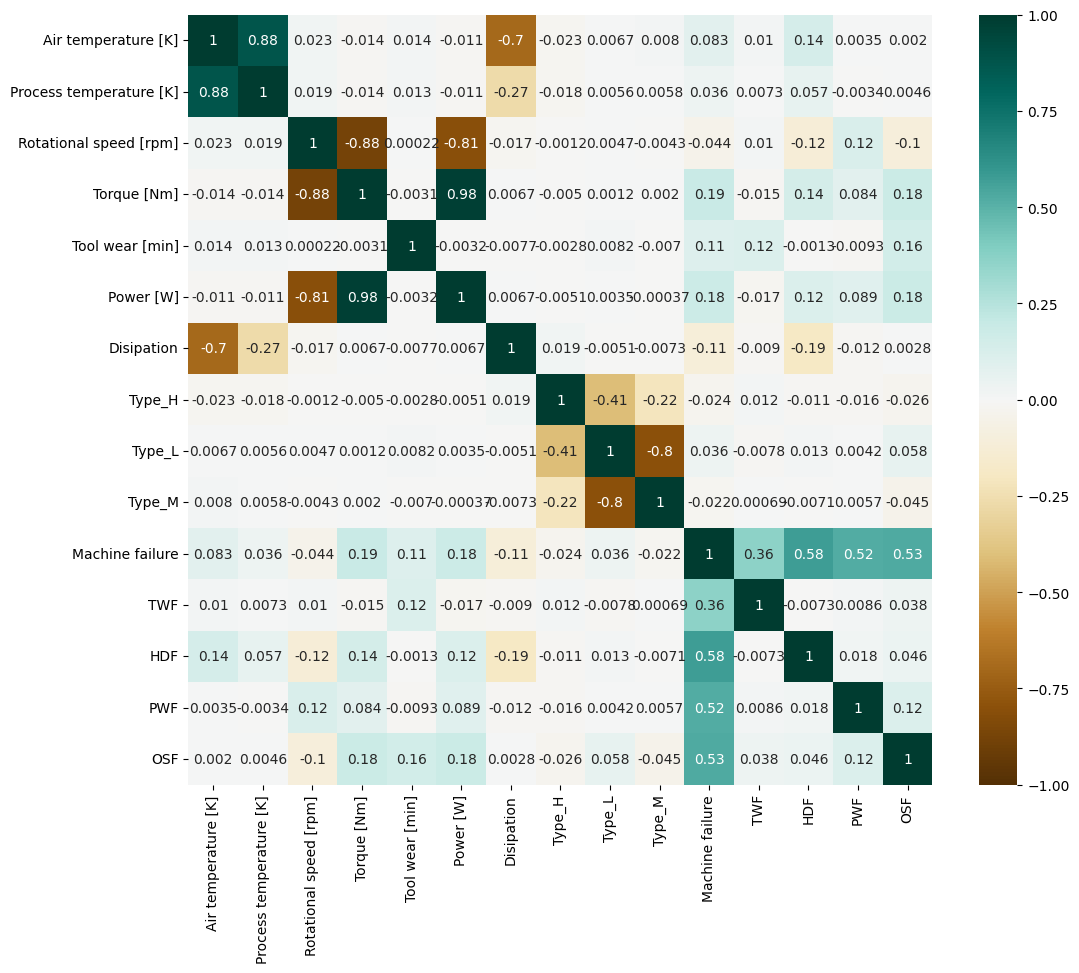

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

### ***SEGUNDO CASO: ESTUDIO DE PREDICCIÓN DE TIPO DE FALLO:***


Qué hago con los modos de fallo (sobre todo con los mixtos)? Es necesario hacer un modelo de machine?

Nos quedamos con el dataframe donde solo se haya prorducido fallo, ya que será con ese donde predeciremos el tipo:

In [13]:
df_type=df[df['Machine failure']==1]

In [14]:
df_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 51 to 9975
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               339 non-null    object 
 1   Air temperature [K]      339 non-null    float64
 2   Process temperature [K]  339 non-null    float64
 3   Rotational speed [rpm]   339 non-null    int64  
 4   Torque [Nm]              339 non-null    float64
 5   Tool wear [min]          339 non-null    int64  
 6   Power [W]                339 non-null    float64
 7   Disipation               339 non-null    float64
 8   Type_H                   339 non-null    bool   
 9   Type_L                   339 non-null    bool   
 10  Type_M                   339 non-null    bool   
 11  Machine failure          339 non-null    int64  
 12  TWF                      339 non-null    int64  
 13  HDF                      339 non-null    int64  
 14  PWF                      339 

In [15]:
df_type.head()

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Disipation,Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,,
51,L47230,298.9,309.1,2861,4.6,143,1378.174809,10.2,False,True,False,1,0,0,1,0
70,L47249,298.9,309.0,1410,65.7,191,9700.923955,10.1,False,True,False,1,0,0,1,1
78,L47257,298.8,308.9,1455,41.3,208,6292.767165,10.1,False,True,False,1,1,0,0,0
161,L47340,298.4,308.2,1282,60.7,216,8149.019072,9.8,False,True,False,1,0,0,0,1
162,L47341,298.3,308.1,1412,52.3,218,7733.302588,9.8,False,True,False,1,0,0,0,1


In [16]:

import tensorflow as tf
from tensorflow import keras



In [17]:
# Definir variables de entrada y salida
X_t = df_type.drop(columns=['TWF', 'HDF', 'PWF', 'OSF', 'Machine failure','Disipation','Power [W]', 'Product ID'])  # Features
y_t = df_type[['TWF', 'HDF', 'PWF', 'OSF']]  # Etiquetas

In [18]:
X_t.head(2)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
UDI,,,,,,,,
51,298.9,309.1,2861,4.6,143,False,True,False
70,298.9,309.0,1410,65.7,191,False,True,False


In [19]:
y_t.head(2)

,TWF,HDF,PWF,OSF
UDI,,,,
51,0,0,1,0
70,0,0,1,1


In [20]:
# Normalizar datos (opcional pero recomendable para redes neuronales)
scaler = StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)

In [21]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_t_scaled, y_t, test_size=0.2, random_state=42)

In [22]:
# Construcción del modelo en Keras
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(4, activation='sigmoid')  # 4 salidas para las etiquetas multietiqueta
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],

              )

In [24]:
earlystopping = keras.callbacks.EarlyStopping(patience=5)

In [25]:
# Entrenar el modelo
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2 ,
                    callbacks = [earlystopping]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3120 - loss: 0.6609 - val_accuracy: 0.3091 - val_loss: 0.6227
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4318 - loss: 0.5787 - val_accuracy: 0.4545 - val_loss: 0.5544
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4765 - loss: 0.5154 - val_accuracy: 0.5818 - val_loss: 0.5069
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6166 - loss: 0.4452 - val_accuracy: 0.6000 - val_loss: 0.4674
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6319 - loss: 0.4169 - val_accuracy: 0.6727 - val_loss: 0.4295
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7053 - loss: 0.3602 - val_accuracy: 0.6909 - val_loss: 0.3806
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7240 - loss: 0.3164 - val_accuracy: 0.6727 - val_loss: 0.3439
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8201 - loss: 0.2663 - val_accuracy: 0.6909 - 

<Axes: >

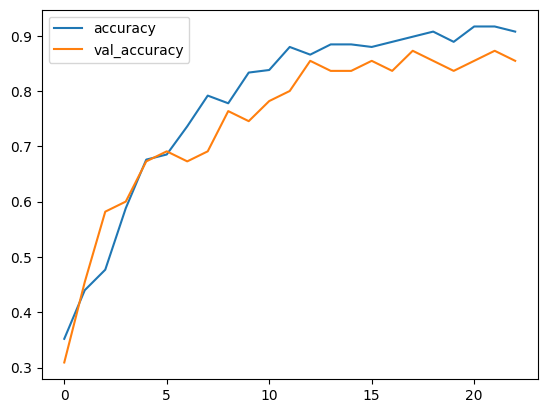

In [26]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()

In [27]:
# Predicciones
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [28]:
np.round(y_pred,2)

array([[0.01, 0.  , 0.05, 1.  ],
       [0.27, 0.77, 0.01, 0.02],
       [0.02, 0.59, 0.01, 0.74],
       [0.93, 0.  , 0.  , 0.03],
       [0.01, 0.99, 0.  , 0.  ],
       [0.03, 0.17, 0.06, 0.8 ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.01, 0.  , 0.09, 0.99],
       [0.96, 0.  , 0.01, 0.01],
       [0.  , 1.  , 0.  , 0.  ],
       [0.08, 0.49, 0.01, 0.45],
       [0.01, 0.04, 0.13, 0.98],
       [0.  , 0.97, 0.01, 0.11],
       [0.  , 0.99, 0.01, 0.  ],
       [0.  , 0.73, 0.08, 0.58],
       [0.  , 0.99, 0.01, 0.  ],
       [0.01, 0.  , 0.01, 0.99],
       [0.62, 0.12, 0.03, 0.  ],
       [0.01, 0.  , 0.01, 0.99],
       [0.97, 0.01, 0.01, 0.01],
       [0.89, 0.  , 0.03, 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.96, 0.08, 0.  ],
       [0.01, 0.99, 0.  , 0.01],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.99, 0.01, 0.  ],
       [0.25, 0.84, 0.  , 0.01],
       [0.  , 0.97, 0.03, 0.  ],
       [0.67, 0.  , 0.  , 0.25],
       [0.

In [29]:
y_pred_binary = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas binarias
y_pred_binary


array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0,

In [30]:
# Evaluación
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.80      0.95      0.87        21
           2       0.79      0.92      0.85        12
           3       1.00      0.78      0.88        23

   micro avg       0.87      0.86      0.87        71
   macro avg       0.88      0.86      0.86        71
weighted avg       0.89      0.86      0.87        71
 samples avg       0.87      0.85      0.85        71



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Vamos a realizar una matriz de confusión para ver los resultados más claramente:


In [31]:
y_test_lista=np.array(y_test.values)

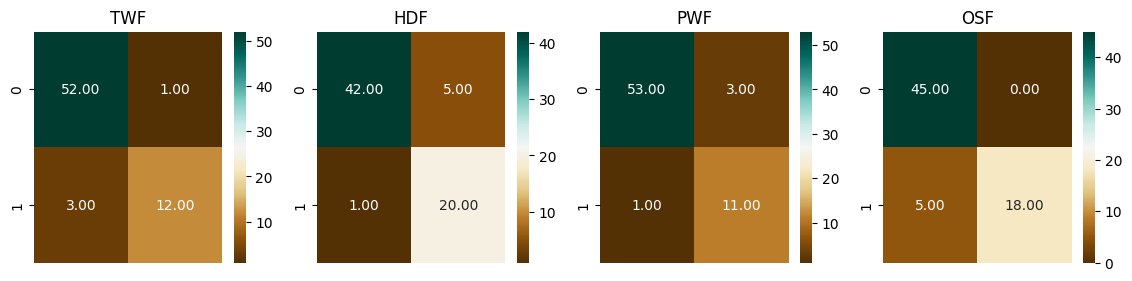

In [32]:
plt.figure(figsize=(14,3))
title_data=['TWF', 'HDF', 'PWF', 'OSF']

for i in range(y_pred_binary.shape[1]):
  y_pred_binary_clas=list()
  y_test_lista_clas=list()
  for j in range(y_pred_binary.shape[0]):
    if y_pred_binary[j][i]==1:
      y_pred_binary_clas.append(1)
    else:
      y_pred_binary_clas.append(0)
    if y_test_lista[j][i]==1:
      y_test_lista_clas.append(1)
    else:
      y_test_lista_clas.append(0)
  #plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.subplot(1,4,i+1)
  sns.heatmap(confusion_matrix(y_test_lista_clas, y_pred_binary_clas), annot=True, cmap='BrBG', fmt=".2f")
  plt.xticks([])
  plt.title(title_data[i],fontsize=12)

In [38]:
X_t.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')

In [43]:
input_data = np.array([298.9, 309.1, 2861, 4.6, 143, 0, 1, 0])
input_data = np.expand_dims(input_data, axis=0)  # Cambia la forma a (1, 8)

In [48]:
model.predict(scaler.transform(input_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


array([[1.1427876e-04, 1.0344130e-06, 9.9986547e-01, 5.5992678e-07]],
      dtype=float32)

In [ ]:
#En el caso de hacer fallos excluyentes
#confusion_matrix(y_test.values.argmax(axis=1), y_pred_binary.argmax(axis=1))

In [ ]:
#En el caso de hacer fallos excluyentes
#sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred_binary.argmax(axis=1),normalize='true'), annot=True, cmap='BrBG', fmt=".2f")

In [49]:
model.save('model_types.keras')